In [1]:
import os
import glob

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
#aggregating collected data
paths = glob.glob('./BTC/BTC*.zip')

raw = None

for i in range(len(paths)):
    if raw is None:
        raw = pd.read_csv('BTC/BTC_Book_' + str(i) + '.zip', 
                                   compression = 'zip', index_col = 0, parse_dates = True)
    else:
        app_data = pd.read_csv('BTC/BTC_Book_' + str(i) + '.zip', 
                               compression = 'zip', index_col = 0, parse_dates = True)
        raw = raw.append(app_data)
        
raw.head(1)        

,Sequence,Bid_1_Price,Bid_1_Size,Bid_1_Trades,Bid_2_Price,Bid_2_Size,Bid_2_Trades,Bid_3_Price,Bid_3_Size,Bid_3_Trades,...,Ask_47_Trades,Ask_48_Price,Ask_48_Size,Ask_48_Trades,Ask_49_Price,Ask_49_Size,Ask_49_Trades,Ask_50_Price,Ask_50_Size,Ask_50_Trades
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-03 17:06:34.424123-04:00,13321475728,6708.69,0.44705,1,6705.57,0.433865,1,6705.56,3.8,1,...,1,6741.24,1.334,1,6743.0,0.058299,1,6743.06,0.927,1


In [3]:
prices = raw[raw.columns[1::3]]
sizes = raw[raw.columns[2::3]]
trades = raw[raw.columns[3::3]]

guess = pd.read_csv('./guess.csv', parse_dates = True, index_col = 0)

In [4]:
#Original Features
feature_data = pd.DataFrame((prices['Bid_1_Price'] + prices['Ask_1_Price'])/2, columns = ['Mid_Price'])

feature_data['Spread'] = prices['Ask_1_Price'] - prices['Bid_1_Price']
feature_data['Bid_Dist'] = prices['Bid_1_Price'] - prices['Bid_50_Price']
feature_data['Ask_Dist'] = prices['Ask_50_Price'] - prices['Ask_1_Price']

feature_data['Level_1_Size_IMB'] = sizes['Ask_1_Size'] - sizes['Bid_1_Size']
feature_data['Ask_1_Size'] = sizes['Ask_1_Size']
feature_data['Bid_1_Size'] = sizes['Bid_1_Size']

bid_sizes = sizes[sizes.columns[:50]]
feature_data['Cumu_Bids'] = bid_sizes.cumsum(axis=1)['Bid_50_Size']

ask_sizes = sizes[sizes.columns[50:]]
feature_data['Cumu_Asks'] = ask_sizes.cumsum(axis=1)['Ask_50_Size']

feature_data['Cumu_Size_IMB'] = feature_data['Cumu_Asks'] - feature_data['Cumu_Bids']

In [5]:
#New Features
def count_values_in_range(series, range_min, range_max):
    # "between" returns a boolean Series equivalent to left <= series <= right.
    # NA values will be treated as False.
    return series.between(left=range_min, right=range_max).sum()

range_min, range_max = 1.3, 9999

a = 50
#These feature_data represent the cumulative Bid/Ask Size Ratio at different order book depths
feature_data['BA1'] = sizes['Bid_1_Size'] / sizes['Ask_1_Size']
feature_data['BA2'] = (sizes['Bid_1_Size'] + sizes['Bid_2_Size']) / (sizes['Ask_1_Size'] + sizes['Ask_2_Size'])
feature_data['BA4']= sizes.iloc[:,0:4].sum(axis=1)/sizes.iloc[:,50:54].sum(axis=1)
feature_data['BA8'] = sizes.iloc[:,0:8].sum(axis=1)/sizes.iloc[:,50:58].sum(axis=1)
feature_data['BA13'] = sizes.iloc[:,0:13].sum(axis=1)/sizes.iloc[:,50:63].sum(axis=1)
feature_data['BA16'] = sizes.iloc[:,0:16].sum(axis=1)/sizes.iloc[:,50:66].sum(axis=1)
feature_data['BA32'] = sizes.iloc[:,0:32].sum(axis=1)/sizes.iloc[:,50:82].sum(axis=1)
feature_data['BA50'] = sizes.iloc[:,0:50].sum(axis=1)/sizes.iloc[:,50:100].sum(axis=1)

#These feature_data implement cluster detection numerically, not in a boolean fashion
feature_data['BCluster 3:5'] = sizes.iloc[:,2:5].sum(axis=1)/(sizes.iloc[:,0:3].sum(axis=1)+sizes.iloc[:,5:8].sum(axis=1))
feature_data['BCluster 5:7'] = sizes.iloc[:,4:7].sum(axis=1)/(sizes.iloc[:,1:4].sum(axis=1)+sizes.iloc[:,7:10].sum(axis=1))
feature_data['BCluster 7:9'] = sizes.iloc[:,6:9].sum(axis=1)/(sizes.iloc[:,3:6].sum(axis=1)+sizes.iloc[:,9:12].sum(axis=1))
feature_data['BCluster 9:11'] = sizes.iloc[:,8:11].sum(axis=1)/(sizes.iloc[:,5:8].sum(axis=1)+sizes.iloc[:,11:14].sum(axis=1))
feature_data['BCluster 11:13'] = sizes.iloc[:,10:13].sum(axis=1)/(sizes.iloc[:,7:10].sum(axis=1)+sizes.iloc[:,13:16].sum(axis=1))
feature_data['BCluster 13:15'] = sizes.iloc[:,12:15].sum(axis=1)/(sizes.iloc[:,9:12].sum(axis=1)+sizes.iloc[:,15:18].sum(axis=1))
feature_data['BCluster 15:17'] = sizes.iloc[:,14:17].sum(axis=1)/(sizes.iloc[:,11:14].sum(axis=1)+sizes.iloc[:,17:20].sum(axis=1))
feature_data['BCluster 17:19'] = sizes.iloc[:,16:19].sum(axis=1)/(sizes.iloc[:,13:16].sum(axis=1)+sizes.iloc[:,19:22].sum(axis=1))
feature_data['BCluster 19:21'] = sizes.iloc[:,18:21].sum(axis=1)/(sizes.iloc[:,15:18].sum(axis=1)+sizes.iloc[:,21:24].sum(axis=1))
feature_data['BCluster 21:23'] = sizes.iloc[:,20:23].sum(axis=1)/(sizes.iloc[:,17:20].sum(axis=1)+sizes.iloc[:,23:26].sum(axis=1))
feature_data['BCluster 23:25'] = sizes.iloc[:,22:25].sum(axis=1)/(sizes.iloc[:,19:22].sum(axis=1)+sizes.iloc[:,25:28].sum(axis=1))

#These feature_data implement cluster detection numerically, not in a boolean fashion
feature_data['ACluster 3:5'] = sizes.iloc[:,2+a:5+a].sum(axis=1)/(sizes.iloc[:,0+a:3+a].sum(axis=1)+sizes.iloc[:,5+a:8+a].sum(axis=1))
feature_data['ACluster 5:7'] = sizes.iloc[:,4+a:7+a].sum(axis=1)/(sizes.iloc[:,1+a:4+a].sum(axis=1)+sizes.iloc[:,7+a:10+a].sum(axis=1))
feature_data['ACluster 7:9'] = sizes.iloc[:,6+a:9+a].sum(axis=1)/(sizes.iloc[:,3+a:6+a].sum(axis=1)+sizes.iloc[:,9+a:12+a].sum(axis=1))
feature_data['ACluster 9:11'] = sizes.iloc[:,8+a:11+a].sum(axis=1)/(sizes.iloc[:,5+a:8+a].sum(axis=1)+sizes.iloc[:,11+a:14+a].sum(axis=1))
feature_data['ACluster 11:13'] = sizes.iloc[:,10+a:13+a].sum(axis=1)/(sizes.iloc[:,7+a:10+a].sum(axis=1)+sizes.iloc[:,13+a:16+a].sum(axis=1))
feature_data['ACluster 13:15'] = sizes.iloc[:,12+a:15+a].sum(axis=1)/(sizes.iloc[:,9+a:12+a].sum(axis=1)+sizes.iloc[:,15+a:18+a].sum(axis=1))
feature_data['ACluster 15:17'] = sizes.iloc[:,14+a:17+a].sum(axis=1)/(sizes.iloc[:,11+a:14+a].sum(axis=1)+sizes.iloc[:,17+a:20+a].sum(axis=1))
feature_data['ACluster 17:19'] = sizes.iloc[:,16+a:19+a].sum(axis=1)/(sizes.iloc[:,13+a:16+a].sum(axis=1)+sizes.iloc[:,19+a:22+a].sum(axis=1))
feature_data['ACluster 19:21'] = sizes.iloc[:,18+a:21+a].sum(axis=1)/(sizes.iloc[:,15+a:18+a].sum(axis=1)+sizes.iloc[:,21+a:24+a].sum(axis=1))
feature_data['ACluster 21:23'] = sizes.iloc[:,20+a:23+a].sum(axis=1)/(sizes.iloc[:,17+a:20+a].sum(axis=1)+sizes.iloc[:,23+a:26+a].sum(axis=1))
feature_data['ACluster 23:25'] = sizes.iloc[:,22+a:25+a].sum(axis=1)/(sizes.iloc[:,19+a:22+a].sum(axis=1)+sizes.iloc[:,25+a:28+a].sum(axis=1))

# Cluster Boolean feature_data
askClusters = feature_data.iloc[:, 20:31]
bidClusters = feature_data.iloc[:, 9:20]

#these two calls appear to be about 98% of the blocks runtime

feature_data["BClusterCount"] = bidClusters.apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)
feature_data["AClusterCount"] = askClusters.apply(
    func=lambda row: count_values_in_range(row, range_min, range_max), axis=1)

# these feature_data detect large orders being cancelled near the best bid/ask which should impact price momentarily

feature_data['BA2Change'] = np.nan
feature_data['LargeBidCancelled'] = np.nan
feature_data['LargeAskCancelled'] = np.nan

feature_data['BA2Change'] = feature_data['BA2'] - feature_data['BA2'].shift(1)

# We can use BA4 change to detect order cancellations at a predefined threshold on the 4 best bids and 4 best asks
def label_cancel(row):
    if row['BA2Change'] < -0.75:
          return 1; # LargeBidCanelled
    elif row['BA2Change'] > 0.75:
          return -1  #LargeAskCancelled
    return 0 # neither

feature_data['LargeOrderCancelled'] = feature_data.apply(lambda row: label_cancel(row), axis=1)
feature_data['LargeBidCancelled'] = (feature_data['LargeOrderCancelled'] == 1)
feature_data['LargeAskCancelled'] = (feature_data['LargeOrderCancelled'] == -1)

feature_data

,Mid_Price,Spread,Bid_Dist,Ask_Dist,Level_1_Size_IMB,Ask_1_Size,Bid_1_Size,Cumu_Bids,Cumu_Asks,Cumu_Size_IMB,...,ACluster 17:19,ACluster 19:21,ACluster 21:23,ACluster 23:25,BClusterCount,AClusterCount,BA2Change,LargeBidCancelled,LargeAskCancelled,LargeOrderCancelled
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-03 17:06:34.424123-04:00,6708.695,0.01,28.69,34.36,0.747936,1.194986,0.447050,101.206556,89.559780,-11.646776,...,0.157558,0.841776,0.463099,0.105869,5,2,NaN,False,False,0
2020-04-03 17:06:35.388369-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.157558,0.841776,0.463099,0.105869,5,1,-0.020924,False,False,0
2020-04-03 17:06:36.414534-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.157558,0.841776,0.463099,0.105869,5,1,0.000000,False,False,0
2020-04-03 17:06:37.400652-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.157558,0.841776,0.463099,0.105869,5,1,0.000000,False,False,0
2020-04-03 17:06:38.408623-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.157558,0.841776,0.463099,0.105869,5,1,0.000000,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-14 06:11:31.101122-04:00,6882.055,0.01,18.65,19.40,-5.023841,0.009184,5.033025,83.699180,72.468059,-11.231121,...,0.615021,0.051410,0.166154,4.475790,6,1,545.566465,False,True,-1
2020-04-14 06:11:32.280154-04:00,6882.055,0.01,18.65,19.40,-5.023841,0.009184,5.033025,83.699180,72.468059,-11.231121,...,0.615021,0.051410,0.166154,4.475790,6,1,0.000000,False,False,0
2020-04-14 06:11:33.237645-04:00,6882.055,0.01,18.65,19.40,-5.043841,0.009184,5.053025,84.311967,74.654060,-9.657907,...,3.177060,0.155773,0.065895,0.202945,6,1,1.877524,False,True,-1


In [6]:
feature_data['Guess'] = guess['Guess'].values

In [7]:
feature_data['return_target'] = feature_data['Mid_Price'].diff(1).shift(-1)
sd = feature_data['return_target'].std()

def return_cat(x, stdev):
    if x > (0 + stdev):
        return 1
    if x < (0 - stdev):
        return -1
    else:
        return 0

feature_data['target_cat'] = feature_data['return_target'].apply(return_cat, args = (sd,))
feature_data = feature_data.dropna()
feature_data

,Mid_Price,Spread,Bid_Dist,Ask_Dist,Level_1_Size_IMB,Ask_1_Size,Bid_1_Size,Cumu_Bids,Cumu_Asks,Cumu_Size_IMB,...,ACluster 23:25,BClusterCount,AClusterCount,BA2Change,LargeBidCancelled,LargeAskCancelled,LargeOrderCancelled,Guess,return_target,target_cat
Timestamp,,,,,,,,,,,,,,,,,,,,,
2020-04-03 17:06:35.388369-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.105869,5,1,-0.020924,False,False,0,0.000000,0.0,0
2020-04-03 17:06:36.414534-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.105869,5,1,0.000000,False,False,0,0.000000,0.0,0
2020-04-03 17:06:37.400652-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.105869,5,1,0.000000,False,False,0,0.000000,0.0,0
2020-04-03 17:06:38.408623-04:00,6708.695,0.01,28.69,34.36,0.778807,1.194986,0.416178,101.175685,89.559780,-11.615905,...,0.105869,5,1,0.000000,False,False,0,0.000000,0.0,0
2020-04-03 17:06:39.418874-04:00,6708.695,0.01,28.69,33.90,0.764714,1.180893,0.416178,101.175685,90.108474,-11.067211,...,0.075998,5,2,0.005556,False,False,0,0.000000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-14 06:11:30.111359-04:00,6882.055,0.01,22.57,20.03,-4.764103,0.045127,4.809231,89.249797,78.538103,-10.711693,...,3.426920,6,1,0.000000,False,False,0,0.000000,0.0,0
2020-04-14 06:11:31.101122-04:00,6882.055,0.01,18.65,19.40,-5.023841,0.009184,5.033025,83.699180,72.468059,-11.231121,...,4.475790,6,1,545.566465,False,True,-1,4.321550,0.0,0
2020-04-14 06:11:32.280154-04:00,6882.055,0.01,18.65,19.40,-5.023841,0.009184,5.033025,83.699180,72.468059,-11.231121,...,4.475790,6,1,0.000000,False,False,0,0.000000,0.0,0


In [8]:
#transform skewed features
feature_data['Spread'] = np.log(feature_data['Spread'].values)
feature_data['Bid_1_Size'] = np.log(feature_data['Bid_1_Size'].values)
feature_data['Ask_1_Size'] = np.log(feature_data['Ask_1_Size'].values)
feature_data['Bid_Dist'] = np.log(feature_data['Bid_Dist'].values)
feature_data['Ask_Dist'] = np.log(feature_data['Ask_Dist'].values)

C:\Users\domin\Anaconda3\envs\QT\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\domin\Anaconda3\envs\QT\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\domin\Anaconda3\envs\QT\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_

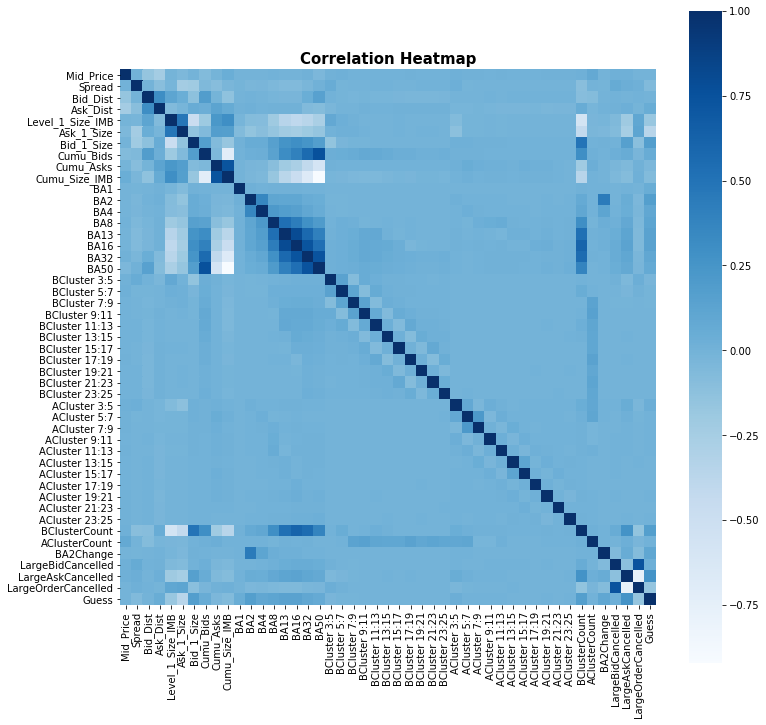

In [12]:
plot_data = feature_data.drop(columns = ['return_target', 'target_cat'])

import seaborn as sns
fig, axs = plt.subplots(1, figsize = (12,12))
axs = sns.heatmap(plot_data.corr(), xticklabels=plot_data.columns, yticklabels=plot_data.columns, square=True,
                 cmap = plt.cm.Blues)
axs.set_title('Correlation Heatmap', weight = 'bold', fontsize = 15)
fig.savefig('feature_correlations.png')

In [10]:
def rolling_window(a, window_size):
    shape = (a.shape[0] - window_size + 1, window_size) + a.shape[1:]
    strides = (a.strides[0],) + a.strides
    return np.lib.stride_tricks.as_strided(a, shape=shape, strides=strides)


features_to_scale = feature_data.drop(columns = ['return_target', 'target_cat'])

X = rolling_window(features_to_scale.values, 30)
X.shape

(909335, 30, 47)

In [11]:
from sklearn.preprocessing import MinMaxScaler

scale_X = np.zeros(X.shape)

time_scaler = MinMaxScaler(feature_range=(-1,1))
for i in range(scale_X.shape[0]):
    sample = X[i]
    time_scaler.fit(sample)
    sample_tr = time_scaler.transform(sample)
    scale_X[i,:,:] = sample_tr.copy()

In [12]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(feature_data['target_cat'].values.reshape(-1,1))

Y = encoder.transform(feature_data['target_cat'].values.reshape(-1,1)).toarray()
Y = Y[29:] #account for time step window

In [14]:
X_train = scale_X[:700000]
Y_train = Y[:700000]

X_test = scale_X[700000:]
Y_test = Y[700000:]

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(700000, 30, 47)
(700000, 3)
(209335, 30, 47)
(209335, 3)


In [16]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
rus.fit_resample(X_train[:,:,0], Y_train)

Y_res = Y[rus.sample_indices_]
X_res = X[rus.sample_indices_]

print(Y_res.shape)
print(X_res.shape)

(85203, 3)
(85203, 30, 47)


In [17]:
np.save('lstm_train_X.npy', X_res)
np.save('lstm_train_Y.npy', Y_res)

In [18]:
np.save('lstm_test_X_1.npy', X_test[:50000])
np.save('lstm_test_X_2.npy', X_test[50000:100000])
np.save('lstm_test_X_3.npy', X_test[100000:150000])
np.save('lstm_test_X_4.npy', X_test[150000:])

np.save('lstm_test_Y_1.npy', Y_test[:50000])
np.save('lstm_test_Y_2.npy', Y_test[50000:100000])
np.save('lstm_test_Y_3.npy', Y_test[100000:150000])
np.save('lstm_test_Y_4.npy', Y_test[150000:])

In [27]:
for line in X_res[0].astype(float):
    for item in line:
        print(item)

7084.795
-4.605170185966264
3.3813347525658988
2.7549337870010766
-3.1903148100000003
-4.71472727272323
1.1629248842864326
109.80523290999999
84.49406611999999
-25.31116679
356.97014720535225
458.5560096001832
57.87822977544057
3.0496430784370925
1.8884410423491205
1.9252018123349115
2.340844164732568
1.2995614716192334
0.06988766252673564
0.4905896461513713
0.6436862036739448
0.48300779887955175
0.6601655846319262
0.4535759961539862
0.7597378523842435
0.2821571326861938
0.3760160206476525
1.0116190089515218
0.6613008628318008
0.020298691810303093
0.13747599672843944
0.41935704007830954
1.2086519222419705
0.10479635357782523
0.6239543252656329
0.7975269655497653
0.0018439549440565717
1.2696297469093607
0.026183779006068112
1.185428447753285
7.0
0.0
458.44673304848067
0.0
1.0
-1.0
3.2030963060000004
7084.795
-4.605170185966264
3.3813347525658988
2.7549337870010766
-3.1903148100000003
-4.71472727272323
1.1629248842864326
109.80523290999999
84.49406611999999
-25.31116679
356.9701472053522